# Attention Head Contribution to Alignment

In [1]:
import os
import sys
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

sys.path.insert(0, "..")

from circuit_brain.dproc import HarryPotter
from circuit_brain.visual import heatmap 

/BRAIN/circuit-alignment/work/miniconda3/envs/ca-dgx1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
m = pickle.load(open("/BRAIN/circuit-alignment/work/circuit-brain-prune/gpt2-7b-hf-norm-single.pkl", "rb"))

<Axes: >

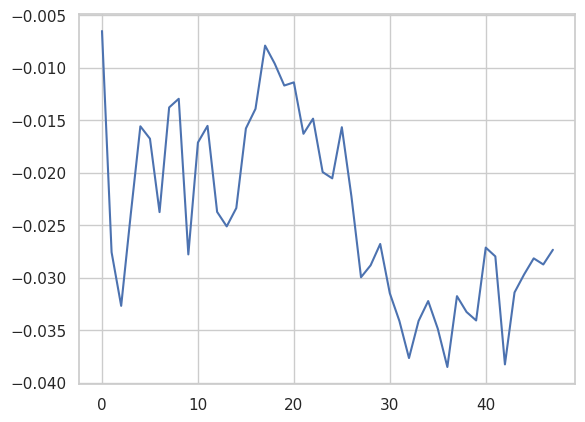

In [28]:
sns.lineplot(m.mean(1))

In [10]:
model = "llama2-13b-hf"
methods = ["norm", "plato", "randtok"]
baselines = [pickle.load(open(f"../{model}-{methods[j]}.pkl", "rb")) for j in range(len(methods))]

In [11]:
sns.set_theme()
sns.set_style("whitegrid")

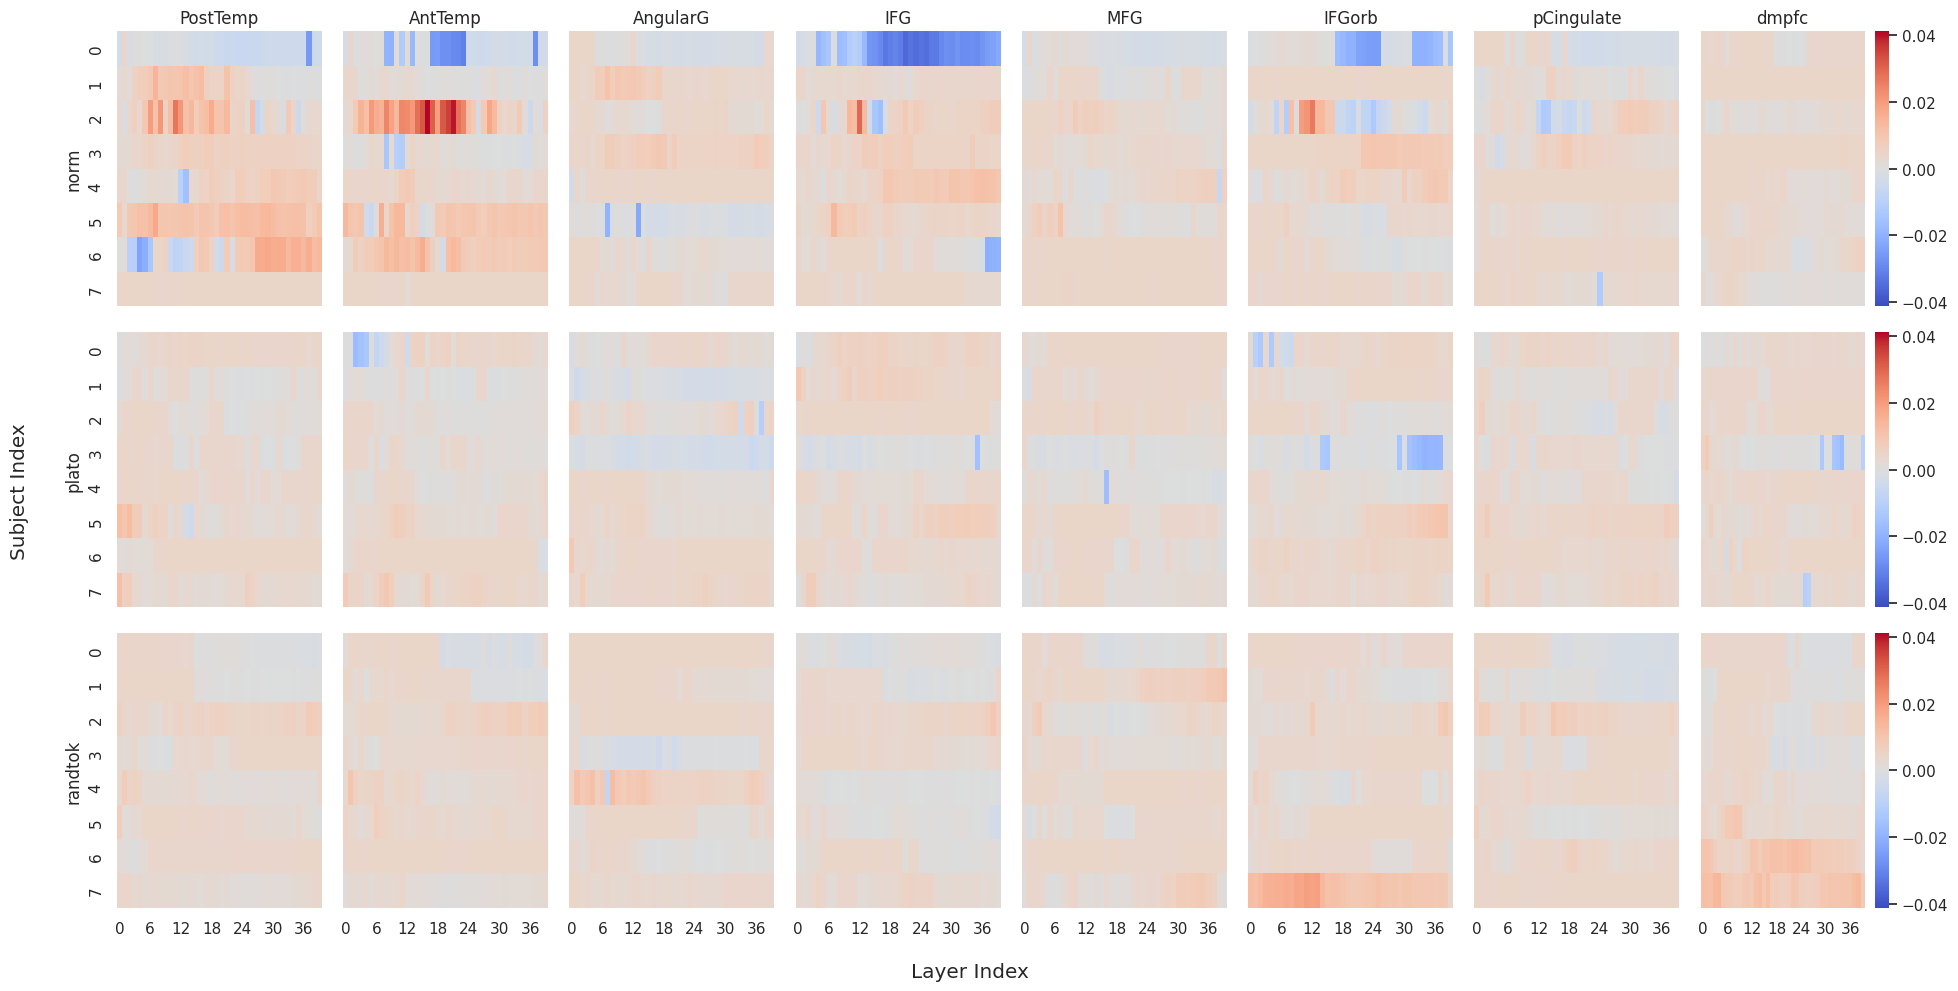

In [12]:
fig, axs = plt.subplots(len(methods),8,figsize=(20,10),sharey=True, sharex=True, squeeze=False)
for j in range(len(methods)):
    baseline = torch.stack(baselines[j])
    if j == 0:
        ls = max(-torch.min(baseline).item(), torch.max(baseline).item())
    for i in range(8):
        sns.heatmap(baseline[...,i], ax=axs[j,i], cmap="coolwarm", vmin=-ls, vmax=ls, cbar=(i==7))
        if j == 0:
            axs[j,i].set_title(HarryPotter.rois[i])
        if i == 0:
            axs[j,i].set_ylabel(methods[j])
fig.supylabel("Subject Index")
fig.supxlabel("Layer Index")
fig.tight_layout(rect=[0.02, 0, 1,1])
plt.savefig(f"{model}-rois-subj-align.pdf")

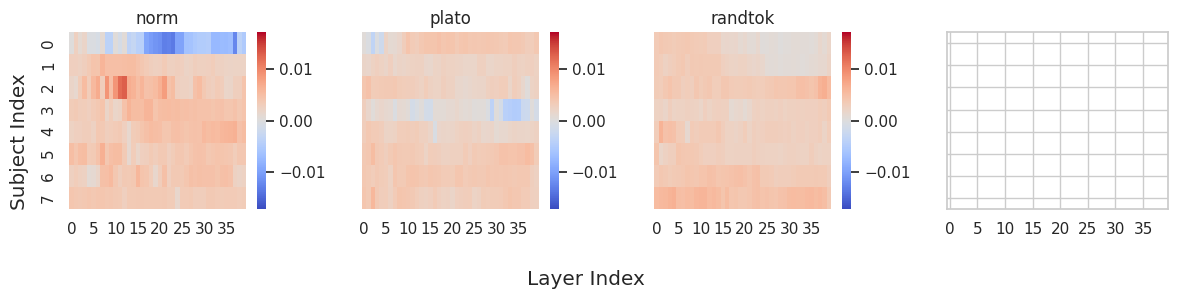

In [13]:
fig, axs = plt.subplots(1,4,figsize=(12,3),sharey=True, sharex=True)

for j in range(len(methods)):
    baseline = torch.stack(baselines[j]).mean(2)
    ls = max(-torch.min(baseline).item(), torch.max(baseline).item())
    sns.heatmap(baseline, ax=axs[j], cmap="coolwarm", vmin=-0.017, vmax=0.017, cbar=(i==7))
    axs[j].set_title(methods[j])
    
fig.supylabel("Subject Index")
fig.supxlabel("Layer Index")
fig.tight_layout()

In [7]:
torch.stack(baselines[0]).shape

torch.Size([8, 32, 8])

IndexError: list index out of range

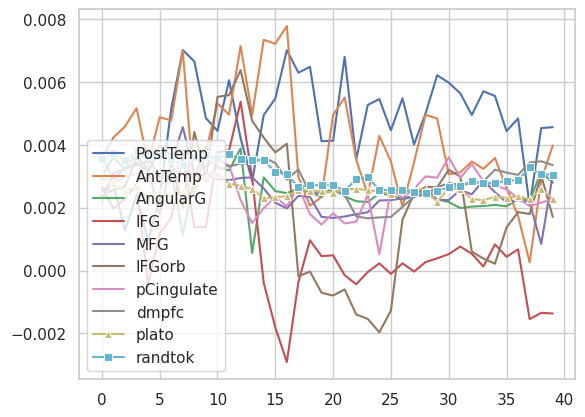

In [14]:
for i in range(8):
    sns.lineplot(torch.stack(baselines[0])[...,i].mean(0), label=f"{HarryPotter.rois[i]}")
sns.lineplot(torch.stack(baselines[1]).mean(0).mean(1), marker="^", label="plato")
sns.lineplot(torch.stack(baselines[2]).mean(0).mean(1), marker="s", label="randtok")
ax = sns.lineplot(torch.stack(baselines[3]).mean(0).mean(1), marker="o", label="poa")
sns.move_legend(ax, "upper left", frameon=False, bbox_to_anchor=(1, 1), title=None)
ax.set_ylabel("Pearson Correlation")
ax.set_xlabel("Layer Index")

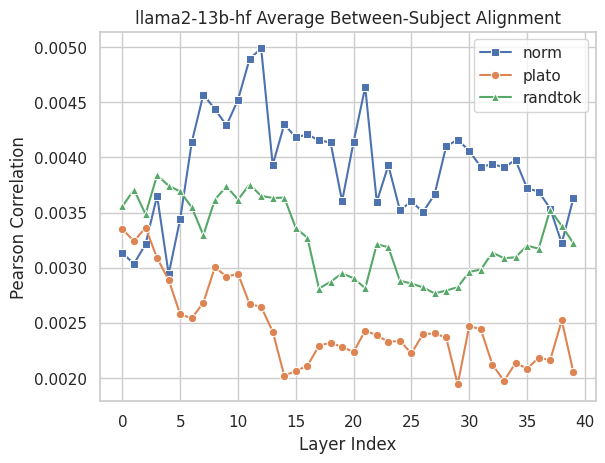

In [17]:
# average across all of the subjects and plot
markers = ["s", "o", "^", "X"]
for i in range(len(methods)):
    ax = sns.lineplot(torch.stack(baselines[i])[1:].mean(0).mean(1), marker=markers[i], label=methods[i])
ax.set_title(f"{model} Average Between-Subject Alignment")
ax.set_ylabel("Pearson Correlation")
ax.set_xlabel("Layer Index")
plt.savefig(f"{model}-avg-between-subj-align.pdf")

In [361]:
# get all of the patched results
subjs = list(range(1))
contr = [pickle.load(open(f"../{model}-plato-subj{i}.pkl", "rb")) for i in subjs]
n_layers = contr

In [362]:
n_layers = max(map(lambda x: int(x.split(".")[0]), contr[0].keys())) + 1 
n_heads = max(map(lambda x: int(x.split(".")[1]), contr[0].keys()))

In [367]:
# calculate the percentage difference between alignment
pcontr = [
    {k: (baseline[i]-v)/abs(baseline[i]-cbaseline[i]) for k,v in contr[i].items()}
    for i in subjs
]

RuntimeError: The size of tensor a (8) must match the size of tensor b (12) at non-singleton dimension 1

In [255]:
# average across all the tensors
pcontr = {
    k: torch.stack([pcontr[i][k] for i in subjs]).mean(0) for k, v in pcontr[0].items()
}

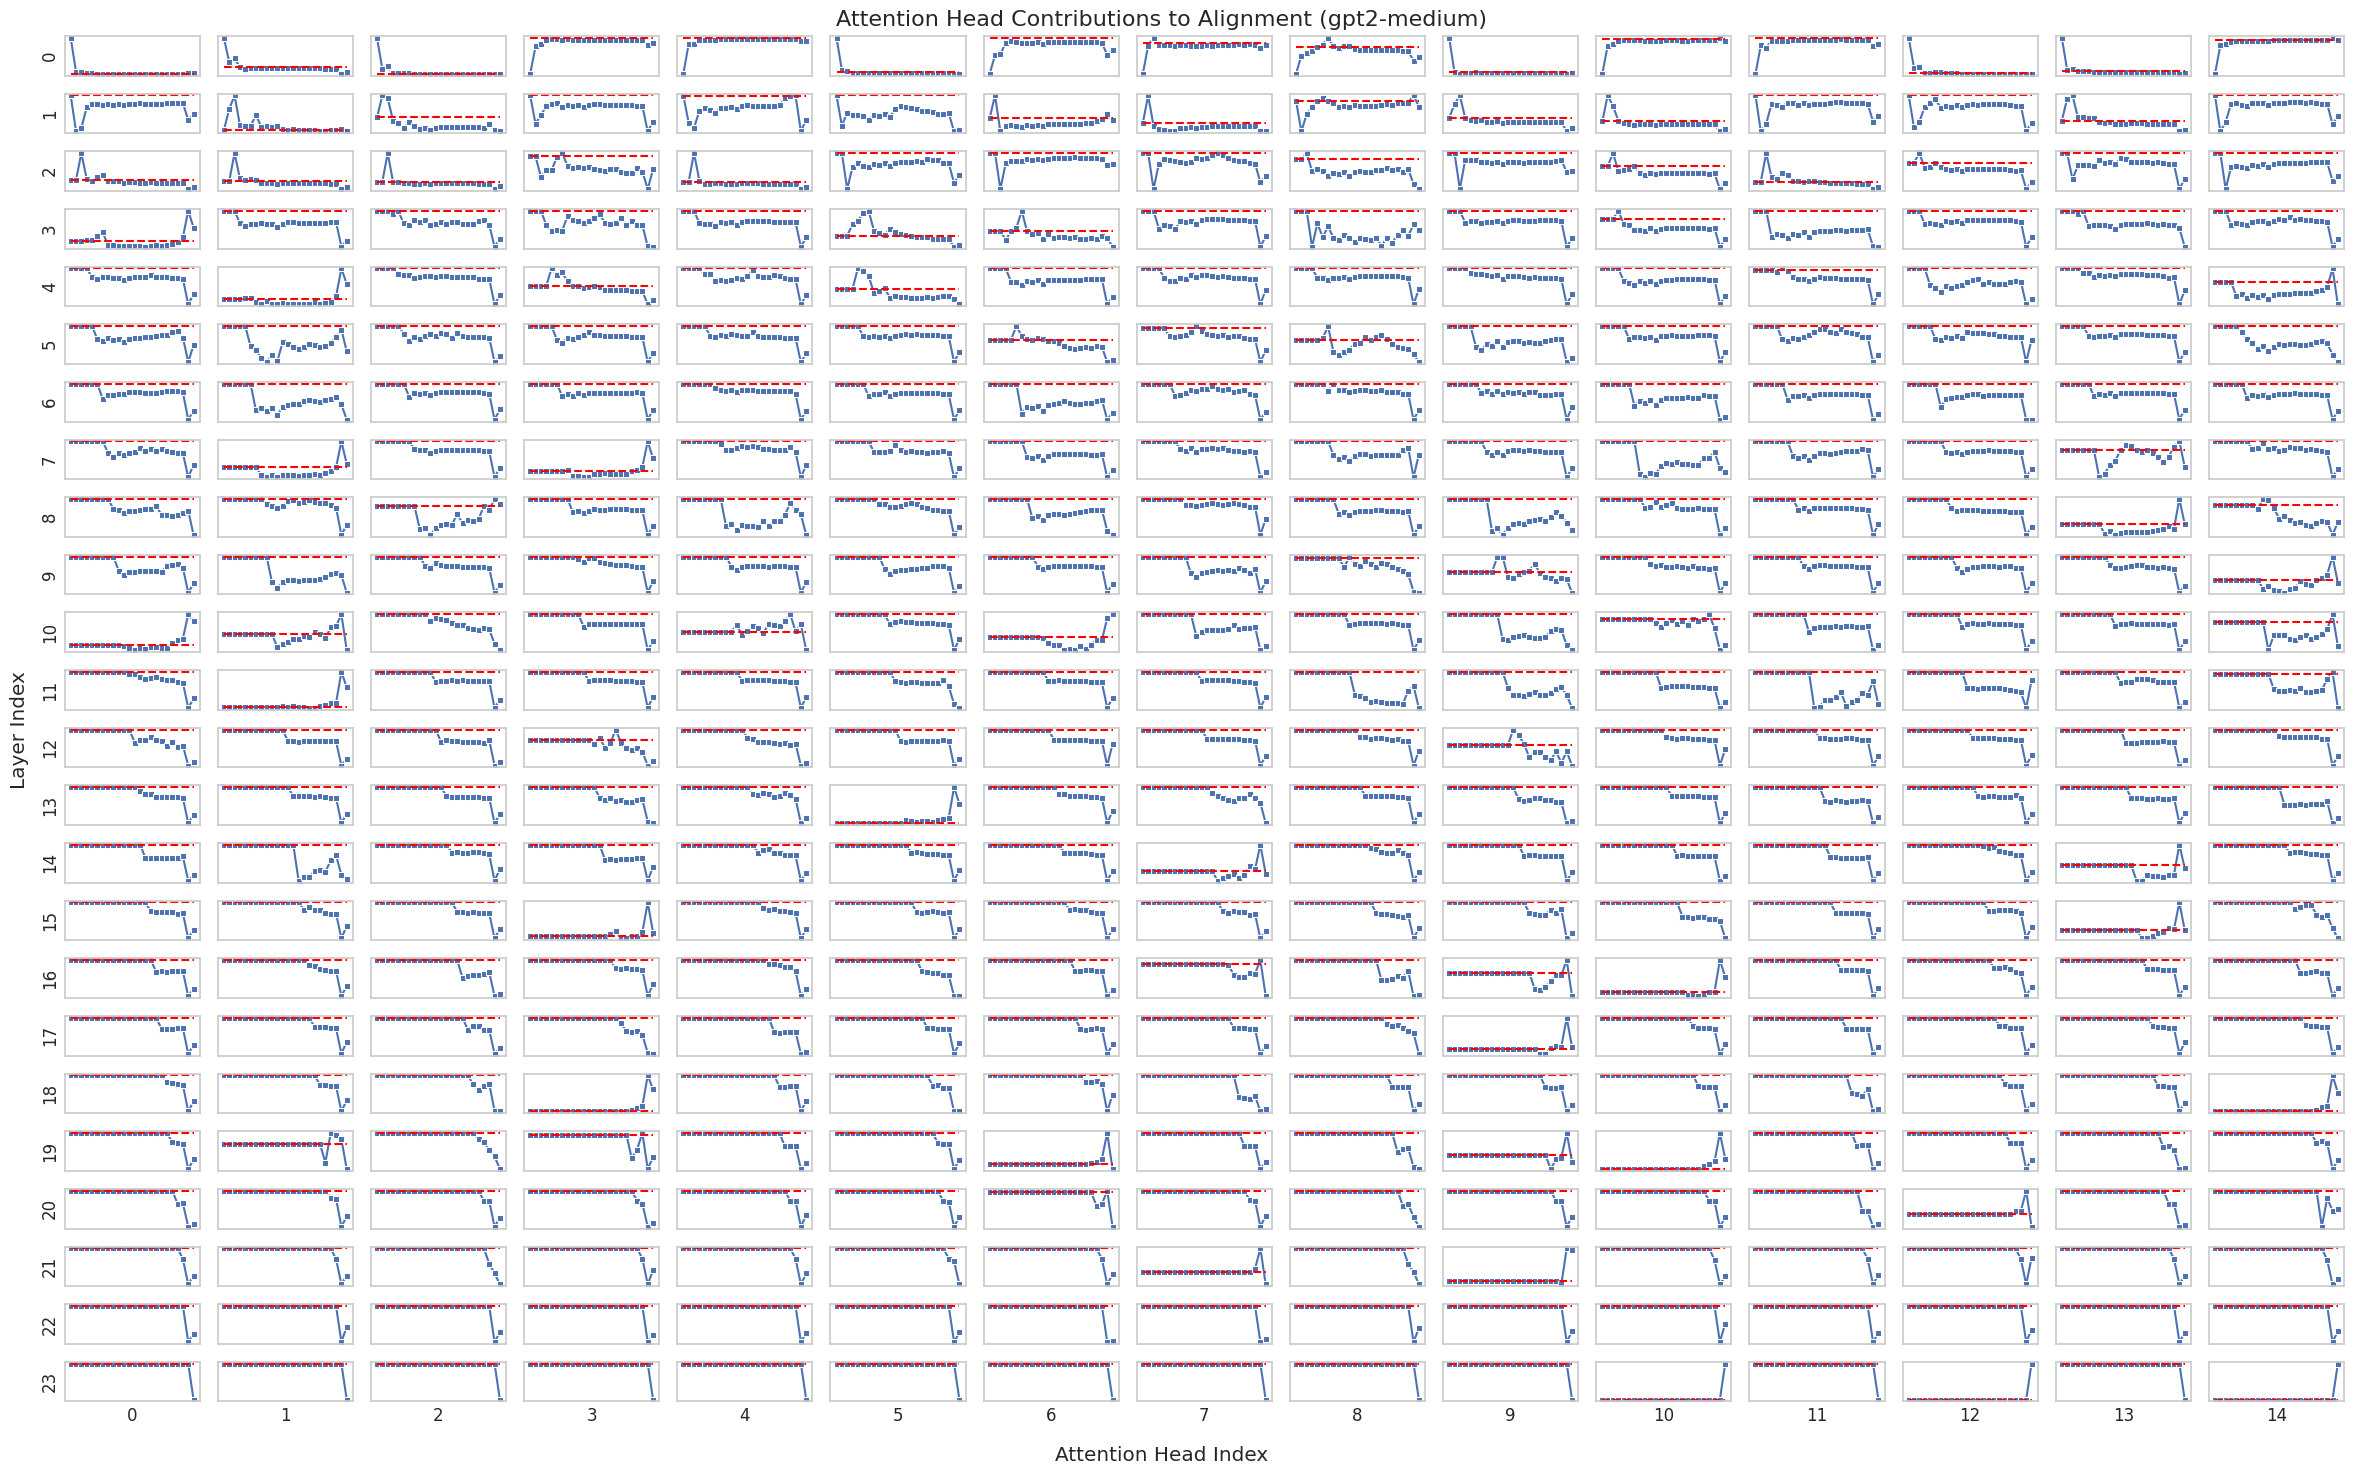

In [261]:
fig, ax = plt.subplots(n_layers,n_heads, figsize=(n_layers,n_heads))
for i in range(n_layers):
    for j in range(n_heads):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j == 0:
            ax[i,j].set_ylabel(i)
        if i == n_layers-1:
            ax[i,j].set_xlabel(j)
        ahc = torch.clone(pcontr[f"{i}.{j}"])
        ahc[:i] = 0.
        sns.lineplot(ahc, ax=ax[i,j], marker="s", markersize=4)
        sns.lineplot(torch.zeros(n_layers), color="red", ax=ax[i,j], linestyle="dashed")

fig.supxlabel("Attention Head Index")
fig.supylabel("Layer Index")
fig.suptitle(f"Attention Head Contributions to Alignment ({model})", fontsize=16)
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout(rect=[0.01, 0.00, 1, 1])